# Battery Swap Scheduling for UAV Missions

## Introduction

In this Jupyter Notebook, we will explore the process of scheduling battery swaps for unmanned aerial vehicle (UAV) missions. The ability to operate multiple UAVs simultaneously for extended periods is advantageous in various applications, such as surveillance, search and rescue, and environmental monitoring. However, managing drone swarms presents challenges, including ensuring safe operations and minimizing operational costs, particularly concerning the number of human operators required.

A critical limiting factor for UAV endurance is the finite capacity of onboard power sources, typically lithium polymer (LiPo) batteries, which provide flight times ranging from a few minutes to an hour, depending on the drone's size and payload. Our goal is to develop an intelligent scheduling algorithm that determines the optimal moments to interrupt user-defined UAV missions for battery replacements, without directly controlling the missions themselves.

## Approach

Our proposed scheduling algorithm leverages the well-known A* algorithm to efficiently find the optimal times for battery swaps, considering the UAVs' current states and mission progress. This approach differs from existing techniques like Mixed-Integer Linear Programming (MILP) or other optimization methods, which often aim to plan the overall mission itself.

By providing an automated and intelligent scheduling solution for battery swaps, our work aims to address the challenges of extending UAV flight time while maintaining mission continuity and minimizing disruptions to user-defined missions.

## Notebook Overview

In this Jupyter Notebook, we will perform the following steps:

1. Load simulated mission plans from pickled files.
2. Preprocess and prepare the mission plan data for scheduling.
3. Implement the scheduling algorithm to calculate the optimal battery swap schedule.
4. Visualize and analyze the results.

## Prerequisities

In [1]:
!pip install folium matplotlib numpy mavsdk cloudpickle

## Load mission plans

The missions were constructed in QGroundControl as simple Survey, where the regions were constructed using "trace" method. All missions share their parameters, which are altitude = 50 m, trigger dist. = 25 m, spacing = 25 m, angle = 238°and turnaround dist. = 10 m.

Every mission was uploaded to UAV simulated using PX4 SITL and than downloaded using Python implementation of MAVSKD as MissionRaw class. The object with mission was saved using cloudpickle library for further processing and utilization in the mission planner. The download from UAV and saving the mission for backup and possible further reupload to UAV mitigate process which would be needed in real-world application and keeps the investigated scenario as much real as possible.

In [2]:
import cloudpickle
import os
from typing import List
from mavsdk.mission_raw import MissionRaw

# Function to load mission plans from pickled files
def load_mission_plans(directory: str) -> List[List[any]]:
    mission_plans = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            mission_plan = cloudpickle.load(open(file_path, 'rb'))
            mission_plans.append(mission_plan)
    return mission_plans

# Load mission plans from the 'missions' directory
mission_plans = load_mission_plans('missions')

# Example: Print the loaded mission plans
for i, mission_plan in enumerate(mission_plans):
    print(f"Mission Plan {i+1}: {len(mission_plan)} waypoints")

Mission Plan 1: 105 waypoints
Mission Plan 2: 110 waypoints
Mission Plan 3: 95 waypoints
Mission Plan 4: 130 waypoints
Mission Plan 5: 80 waypoints
Mission Plan 6: 110 waypoints
Mission Plan 7: 105 waypoints


## Extracting Local Coordinates from Mission Plans

Before we can proceed with scheduling the battery swaps, we need to extract the relevant information from the mission plans. Specifically, we are interested in the local x, y, and z coordinates of each waypoint in the missions.

According to the MAVSDK API documentation, the coordinates are provided as follows:

- **x**: Stored in the `x_local` attribute of each waypoint, representing the longitude position in degrees (multiplied by 1e7).
- **y**: Stored in the `y_local` attribute of each waypoint, representing the latitude position in degrees (multiplied by 1e7).
- **z**: Stored in the `z_local` attribute of each waypoint, representing the z coordinate or altitude in meters.

To extract these local coordinates, we will define a function `extract_local_coordinates` that takes a single mission plan as input and returns a NumPy array containing the local x, y, and z coordinates for all waypoints in that mission plan.

In [3]:
import numpy as np

def extract_coordinates(mission_plan):
    coordinates = []
    for i, waypoint in enumerate(mission_plan):
        if i < 2:  # Skip the first waypoint
            continue
        x = waypoint.x * 1e-7  # Convert from degrees * 10^7 to degrees
        y = waypoint.y * 1e-7  # Convert from degrees * 10^7 to degrees
        # z = waypoint.z  # Already in meters
        if x != 0 or y != 0:  # Exclude zero values
            coordinates.append([x, y])
            # coordinates.append([x, y, z])
    return np.array(coordinates)

def coordinates2local(coordinates):
    local_coords = []
    for lon, lat in coordinates:
        x = np.radians(lon) * np.cos(np.radians(lat)) * 6378000  # Approximate x in meters
        y = np.radians(lat) * 6378000  # Approximate y in meters
        local_coords.append([x, y])
    return np.array(local_coords)

# Assuming you have loaded the mission plans into 'mission_plans'
coordinates = []
for mission_plan in mission_plans:
    coords = extract_coordinates(mission_plan)
    coordinates.append(coords)

# Convert longitude and latitude to local coordinates (x, y)
local_coordinates = []
for coords in coordinates:
    local_coords = coordinates2local(coords)
    local_coordinates.append(local_coords)

# Visualizing Drone Missions on a Map

We use the folium library to create an interactive map that displays the flight paths of different drone missions. Each mission is represented by a colored polyline, allowing us to visualize the trajectories and identify any patterns or anomalies.

Tutorial for simply convert a Folium map in html to pdf is in https://github.com/moore-austin/AcceleratedLearning/blob/main/Convert_Folium_Map_to_PNG_Without_SELENIUM.ipynb

In [4]:
import folium

# Create a map centered at a specific location (e.g., Center of Borsky park)
center_coords = (49.7206839, 13.3680989)
centerl_local_coords = coordinates2local([center_coords])
my_map = folium.Map(location=center_coords, zoom_start=15, tiles="Cartodb Voyager")

# Define a list of colors for missions (up to 10 missions)
mission_colors = ['#FF0000', '#0000FF', '#00B2A9', '#ff007f', '#800080', '#3182bd', '#00B300', '#00FFFF', '#FF4500', '#FFD700']

# Add markers for each mission plan
for i, coords in enumerate(coordinates):
    color = mission_colors[i % len(mission_colors)]  # Cycle through available colors
    folium.PolyLine(coords, color=color, weight=3, opacity=0.7).add_to(my_map)

station_coordinates = np.array([[49.7216686, 13.3647731],
                  [49.7186203, 13.3688311],
                  [49.7178711, 13.3778406],
                  [49.7190225, 13.3646844],
                  [49.7222408, 13.3619539],
                  [49.7174617, 13.3746675]])

station_local_coordinates = coordinates2local(station_coordinates)

for station_id, station_location in enumerate(station_coordinates, start=1):
    folium.Marker(
        location=station_location,
        tooltip=f"Station {station_id}",  # Display station ID in tooltip
        popup=f"{station_location[0]}N, {station_location[1]}E",
        icon=folium.Icon(color="green"),
    ).add_to(my_map)


# Save the map to an HTML file
my_map.save("missions_map.html")

In [5]:
from IPython.display import IFrame

# Display the map
IFrame(src="missions_map.html", width=800, height=600)


# Iris Drone

The parameters for the unmanned aerial vehicle (UAV) were selected based on the Iris drone, as its model is compatible with the PX4 Autopilot Gazebo SITL. However, the parameters can be readily adapted for use with another vertical take-off and landing (VTOL) model. Moreover, these parameters can be identified in the future online based on measurement to make the mission planner adaptive.

- **Maximum Flight Time:** 22 minutes (adjust based on payload and conditions)
- **Maximum Horizontal Velocity:** 22.7 m/s (approximately 51 mph)
- **Source:** https://productz.com/en/3d-robotics-iris-plus/p/dKa1

In [6]:
from orchestrator_object import Drone, Battery

n_drones = len(coordinates) # each UAV has its own mission
travel_speed = 5 # m/s
flight_time = 20*60 # minutes in air
battery_id = 300 # batteries have IDs 300 + i, i = 1,...,n_drones
batt_cap = 1.0  # battery capacity

drones = []
for i in range(n_drones):
    battery_id = battery_id + 1
    drones.append(Drone(target_system=i+1, battery=Battery(id=battery_id, current_cap=batt_cap),
                        location=local_coordinates[i][0],
                        max_speed=travel_speed,
                        max_flight_time=flight_time))
    # init mission and time plan
    drones[i].new_mission(local_coordinates[i])
    

# Battery Stations

In [7]:
from orchestrator_object import Droneport

n_ports = len(station_coordinates)  # no. of stations
n_slots = 10  # no. of battery charging slots in battery stations

# get random Droneport platforms
ports = []
for i in range(n_ports):
    batteries = []
    # get fully loaded batteries
    for b in range(n_slots):
        battery_id = battery_id + 1
        batteries.append(Battery(id=battery_id))
    ports.append(Droneport(target_system=i+201, batteries=batteries,
                           location=station_local_coordinates[i, :], slots = len(batteries)))

# Initialize Problem and Find Solution

In [8]:
# Find solution with A*

# no mission progress
start = np.zeros(n_drones, dtype=int)
# every mission is completed
end = np.zeros(n_drones, dtype=int)
for drone in drones:
    end[drone.id-1] = drone.mission_count-1

# every mission SEQ:
n_seq = 0
max_seq = 0
for drone in drones:
    n_seq = n_seq + drone.mission_count
    if drone.mission_count > max_seq:
        max_seq = drone.mission_count
# generate possible actions
actions = -1*np.ones((n_ports*n_seq, 3), dtype=int)
actions_cost = -1*np.ones((n_drones, n_ports, max_seq))
actions_time = -1*np.ones((n_drones, n_ports, max_seq))
k = 0
for drone in drones:
    for port in ports:
        soc, time = drone.soc_and_time2point(port.location)
        for i in range(drone.mission_count):
            if time[i][0] > 2*60:
                continue
            actions[k, :] = [drone.id, port.id, i]
            actions_cost[drone.id-1, port.id-201, i] = soc[i][0]
            actions_time[drone.id-1, port.id-201, i] = time[i][0]
            k = k+1

In [9]:
%%time
from astar import AStar

# find solution
astar = AStar(drones, ports, start, end, actions, actions_cost, actions_time, max_iterations = 1e3)
path = astar.plan_missions()
# with full action list even 288 min weren't enough

CPU times: user 4min 37s, sys: 95.9 ms, total: 4min 37s
Wall time: 4min 37s


plan:
[  2 202  33]
[  6 201  43]
[  4 204  33]
[  1 205  31]
[  3 203  29]
[  2 202  39]
[  5 201  15]
[  1 201  38]
[  6 201  54]
[  7 201  38]
schedule:
[202,  0:14:01.426902, 0:17:01.426902]
[201,  0:13:24.817072, 0:16:24.817072]
[204,  0:12:31.641078, 0:15:31.641078]
[205,  0:11:04.579465, 0:14:04.579465]
[203,  0:07:26.319388, 0:10:26.319388]
[202,  0:20:57.012436, 0:23:57.012436]
[201,  0:04:55.660758, 0:07:55.660758]
[201,  0:17:30.738241, 0:20:30.738241]
[201,  0:22:41.139890, 0:25:41.139890]
[201,  0:09:05.583384, 0:12:05.583384]
mission time:
UAV1 original: 0:27:21.149393, final: 0:31:58.677466, difference: 0:04:37.528073
UAV2 original: 0:33:24.016091, final: 0:37:39.075646, difference: 0:04:15.059556
UAV3 original: 0:22:52.777619, final: 0:25:14.804294, difference: 0:02:22.026676
UAV4 original: 0:27:39.529028, final: 0:30:12.689467, difference: 0:02:33.160440
UAV5 original: 0:18:25.914333, final: 0:21:19.103949, difference: 0:02:53.189616
UAV6 original: 0:30:10.609100, fina

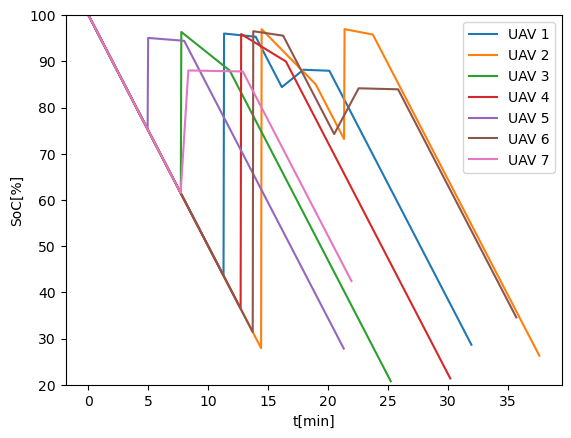

In [10]:
from matplotlib import pyplot as plt
from datetime import timedelta

if path is not None:
    
    plt.figure()
    for i in range(len(path[-1].missions_time)):
        plt.plot(path[-1].missions_time[i]/60.0, path[-1].soc_progress[i]*100, label=f'UAV {i+1}')
    plt.legend()
    plt.ylim(20,100)
    plt.xlabel('t[min]')
    plt.ylabel('SoC[%]')
    # plt.title('State of Charge prediction')
        
# extract solution
if path is not None:
    print("plan:")
    for point in path[1:]: # first node is without action
        print(point.action)

    print("schedule:")
    for window in path[-1].schedule:
        print(f'[{window[0]+201},  {timedelta(seconds = window[1])}, {timedelta(seconds = window[2])}]')
        
    print("mission time:")
    for drone in drones:
        print(f"UAV{drone.id} original: {timedelta(seconds = (drone.time_plan[-1,0]))}, final: {timedelta(seconds = (path[-1].missions_time[drone.id-1][-1,0]))}, difference: {timedelta(seconds = (path[-1].missions_time[drone.id-1][-1,0]-drone.time_plan[-1,0]))}")
        
plt.savefig("imgs/park-soc.pdf", bbox_inches='tight')
plt.show()